# DEMetropolis(Z): Population vs. History efficiency comparison
The idea behind `DEMetropolis` is quite simple: Over time, a population of MCMC chains converges to the posterior, therefore the population can be used to inform joint proposals.
But just like the most recent positions of an entire population converges, so does the history of each individual chain.

In [ter Braak & Vrugt, 2008](https://doi.org/10.1007/s11222-008-9104-9) this history of posterior samples is used in the "DE-MCMC-Z" variant to make proposals.

The implementation in PyMC3 is based on `DE-MCMC-Z`, but a few details are different. Namely, each `DEMetropolisZ` chain only looks into its own history. Also we use a different tuning scheme.

In this notebook, a D-dimenstional multivariate normal target densities are sampled with `DEMetropolis` and `DEMetropolisZ` at different $N_{chains}$ settings.

In [1]:
import arviz as az
import fastprogress
import ipywidgets
import numpy as np
import pandas as pd
import pathlib
import pymc3 as pm
import time

from matplotlib import cm
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.0


## Benchmarking with a D-dimensional MVNormal model
The function below constructs a fresh model for a given dimensionality and runs either `DEMetropolis` or `DEMetropolisZ` with the given settings. The resulting trace is saved with ArviZ.

If the saved trace is already found, it is loaded from disk.

Note that all traces are sampled with `cores=1`. This is because parallelization of `DEMetropolis` chains is slow at $O(N_{chains})$ and the comparison would be different depending on the number of available CPUs.

In [2]:
def get_mvnormal_model(D:int) -> pm.Model:
    true_mu = np.zeros(D)
    true_cov = np.eye(D)
    true_cov[:5,:5] = np.array([
        [1, 0.5, 0, 0, 0],
        [0.5, 2, 2, 0, 0],
        [0, 2, 3, 0, 0],
        [0, 0, 0, 4, 4],
        [0, 0, 0, 4, 5],
    ])

    with pm.Model() as pmodel:
        x = pm.MvNormal('x', mu=true_mu, cov=true_cov, shape=(D,))
    
    true_samples = x.random(size=1000)
    truth_id = az.data.convert_to_inference_data(true_samples[np.newaxis,:], group='random')
    return pmodel, truth_id

def run_setting(D, N_tune, N_draws, N_chains, algorithm):
    savename = f'{algorithm}_{D}_{N_tune}_{N_draws}_{N_chains}.nc'
    print(f'Scenario filename: {savename}')
    if not pathlib.Path(savename).exists():
        pmodel, truth_id = get_mvnormal_model(D)
        with pmodel:
            if algorithm == 'DE-MCMC':
                step = pm.DEMetropolis()
            elif algorithm == 'DE-MCMC-Z':
                step = pm.DEMetropolisZ()
            idata = pm.sample(
                cores=1, tune=N_tune, draws=N_draws, chains=N_chains,
                step=step,
                start={'x': [0]*D},
                discard_tuned_samples=False, return_inferencedata=True
            )
        idata.to_netcdf(savename)
    else:
        idata = az.from_netcdf(savename)
    return idata

## Running the Benchmark Scenarios
Here a variety of different scenarios is computed and the results are aggregated in a multi-indexed DataFrame.

In [3]:
df_results = pd.DataFrame(columns='algorithm,D,N_tune,N_draws,N_chains,t,idata'.split(','))
df_results = df_results.set_index('algorithm,D,N_tune,N_draws,N_chains'.split(','))

for algorithm in {'DE-MCMC', 'DE-MCMC-Z'}:
    for D in (10, 20, 40):
        N_tune = 10000
        N_draws = 10000
        for N_chains in (5,10,20,30,40,80):
            idata = run_setting(D, N_tune, N_draws, N_chains, algorithm)
            t = idata.posterior.sampling_time
            df_results.loc[(algorithm, D, N_tune, N_draws, N_chains)] = (t, idata)

Scenario filename: DE-MCMC-Z_10_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_80.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_80.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_80.nc
Scenario filename: DE-MCMC_10_10000_10000_5.nc
Scenario filename: DE-MCMC_10_10000_10000_10.nc
Scenario

In [4]:
df_results[['t']]

t
algorithm D  N_tune N_draws N_chains            
DE-MCMC-Z 10 10000  10000   5          39.480404
                            10         78.946246
                            20        157.825632
                            30        237.409558
                            40        325.555073
                            80        644.532668
          20 10000  10000   5          40.624523
                            10         80.941480
                            20        160.044703
                            30        240.251857
                            40        318.868806
                            80        633.462279
          40 10000  10000   5          38.424908
                            10         77.183491
                            20        151.545646
                            30        229.622070
                            40        306.582845
                            80        605.868718
DE-MCMC   10 10000  10000   5          41.372329
                            10         79.696340
                            20        161.420276
                            30        241.095004
                            40        325.480585
                            80        673.806912
          20 10000  10000   5          40.897735
                            10         79.167305
                            20        158.598296
                            30        239.134815
                            40        319.663353
                            80        647.283743
          40 10000  10000   5          41.570163
                            10         81.211638
                            20        160.250596
                            30        240.578438
                            40        323.043744
                            80        654.480116

## Analyzing the traces
From the traces, we need to compute the absolute and relative $N_{eff}$ and the $\hat{R}$ to see if we can trust the posteriors.

In [5]:
df_temp = df_results.reset_index(['N_tune', 'N_draws'])
df_temp['N_samples'] = [
    row.N_draws * row.Index[2]
    for row in df_temp.itertuples()
]
df_temp['ess'] = [
    float(az.ess(idata.posterior).x.mean())
    for idata in fastprogress.progress_bar(df_temp.idata)
]
df_temp['rel_ess'] = [
    row.ess / (row.N_samples)
    for row in df_temp.itertuples()
]
df_temp['r_hat'] = [
    float(az.rhat(idata.posterior).x.mean())
    for idata in fastprogress.progress_bar(df_temp.idata)
]
df_temp = df_temp.sort_index(level=['algorithm', 'D', 'N_chains'])

In [6]:
df_temp

N_tune  N_draws           t  \
algorithm D  N_chains                                
DE-MCMC   10 5          10000    10000   41.372329   
             10         10000    10000   79.696340   
             20         10000    10000  161.420276   
             30         10000    10000  241.095004   
             40         10000    10000  325.480585   
             80         10000    10000  673.806912   
          20 5          10000    10000   40.897735   
             10         10000    10000   79.167305   
             20         10000    10000  158.598296   
             30         10000    10000  239.134815   
             40         10000    10000  319.663353   
             80         10000    10000  647.283743   
          40 5          10000    10000   41.570163   
             10         10000    10000   81.211638   
             20         10000    10000  160.250596   
             30         10000    10000  240.578438   
             40         10000    10000  323.043744   
             80         10000    10000  654.480116   
DE-MCMC-Z 10 5          10000    10000   39.480404   
             10         10000    10000   78.946246   
             20         10000    10000  157.825632   
             30         10000    10000  237.409558   
             40         10000    10000  325.555073   
             80         10000    10000  644.532668   
          20 5          10000    10000   40.624523   
             10         10000    10000   80.941480   
             20         10000    10000  160.044703   
             30         10000    10000  240.251857   
             40         10000    10000  318.868806   
             80         10000    10000  633.462279   
          40 5          10000    10000   38.424908   
             10         10000    10000   77.183491   
             20         10000    10000  151.545646   
             30         10000    10000  229.622070   
             40         10000    10000  306.582845   
             80         10000    10000  605.868718   

                                                                   idata  \
algorithm D  N_chains                                                      
DE-MCMC   10 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
          20 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
          40 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
DE-MCMC-Z 10 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t.

## Visualizing Effective Sample Size
In this diagram, we'll plot the relative effective sample size agains the number of chains.

Because our computation above ran everything with $N_{cores}=1$, we can't make a realistic comparison of effective sampling rates.

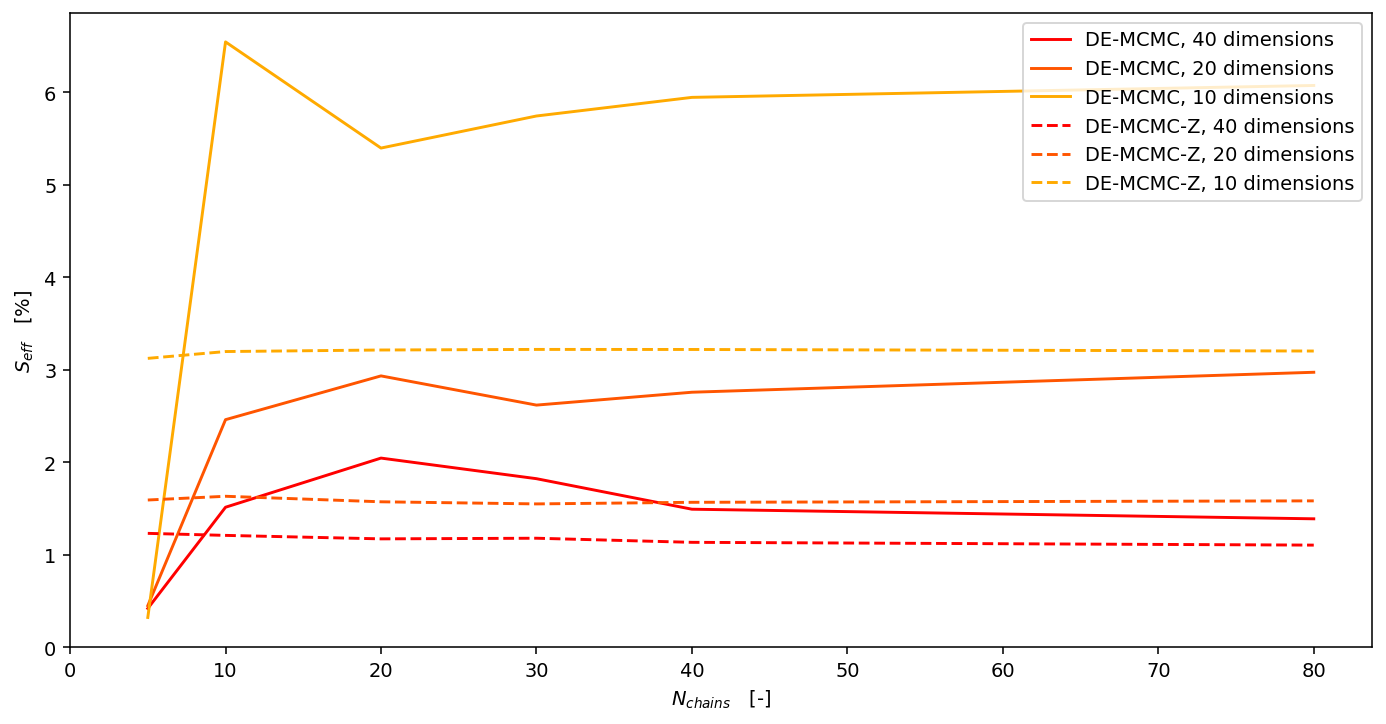

In [7]:
fig, right = plt.subplots(dpi=140, ncols=1, sharey='row', figsize=(12,6))

for algorithm, linestyle in zip(['DE-MCMC', 'DE-MCMC-Z'], ['-', '--']):
    dimensionalities = list(sorted(set(df_temp.reset_index().D)))[::-1]
    N_dimensionalities = len(dimensionalities)
    for d, dim in enumerate(dimensionalities):
        color = cm.autumn(d / N_dimensionalities)
        df = df_temp.loc[(algorithm, dim)].reset_index()
        right.plot(
            df.N_chains,
            df.rel_ess*100,
            linestyle=linestyle,
            color=color,
            label=f'{algorithm}, {dim} dimensions'
        )

right.legend()
right.set_ylabel('$S_{eff}$   [%]')
right.set_xlabel('$N_{chains}$   [-]')
right.set_ylim(0)
right.set_xlim(0)
plt.show()

## Visualizing Computation Time
As all traces were sampled with `cores=1`, we expect the computation time to grow linearly with the number of samples.

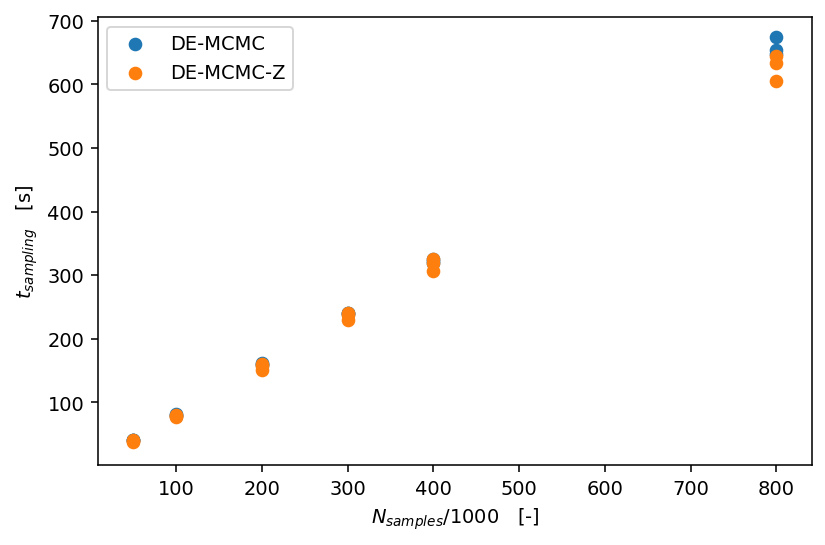

In [8]:
fig, ax = plt.subplots(dpi=140)

for alg in ['DE-MCMC', 'DE-MCMC-Z']:
    df = df_temp.sort_values('N_samples').loc[alg]
    ax.scatter(df.N_samples/1000, df.t, label=alg)
ax.legend()
ax.set_xlabel('$N_{samples} / 1000$   [-]')
ax.set_ylabel('$t_{sampling}$   [s]')
fig.tight_layout()
plt.show()

## Visualizing the Traces
By comparing DE-MCMC and DE-MCMC-Z for a setting such as D=10, $N_{chains}$=5, you can see how DE-MCMC-Z has a clear advantage over a DE-MCMC that is run with too few chains.

In [9]:
def plot_trace(algorithm, D, N_chains):
    n_plot = min(10, N_chains)
    fig, axs = plt.subplots(nrows=n_plot, figsize=(12,2*n_plot))
    idata = df_results.loc[(algorithm, D, 10000, 10000, N_chains), 'idata']
    for c in range(n_plot):
        samples = idata.posterior.x[c,:,0]
        axs[c].plot(samples, linewidth=0.5)
    plt.show();
    return

ipywidgets.interact_manual(
    plot_trace,
    algorithm=['DE-MCMC', 'DE-MCMC-Z'],
    D=sorted(set(df_results.reset_index().D)),
    N_chains=sorted(set(df_results.reset_index().N_chains)),
);

interactive(children=(Dropdown(description='algorithm', options=('DE-MCMC', 'DE-MCMC-Z'), value='DE-MCMC'), Dr…

## Inspecting the Sampler Stats
With the following widget, you can explore the sampler stats to better understand the tuning phase.

The `tune=None` default setting of `DEMetropolisZ` is the most robust tuning strategy. However, setting `tune='lambda'` can improves the initial convergence by doing a swing-in that makes it diverge much faster than it would with a constant `lambda`. The downside of tuning `lambda` is that if the tuning is stopped too early, it can get stuck with a very inefficient `lambda`.

Therefore, you should always inspect the `lambda` and rolling mean of `accepted` sampler stats when picking $N_{tune}$.

In [11]:
def plot_stat(*, sname:str='accepted', rolling=True, algorithm, D, N_chains):
    fig, ax = plt.subplots(ncols=1, figsize=(12,7), sharey='row')
    row = df_results.loc[(algorithm, D, 10000, 10000, N_chains)]
    for c in df_results.idata[0].posterior.chain:
        S = np.hstack([
            #idata.warmup_sample_stats[sname].sel(chain=c),
            idata.sample_stats[sname].sel(chain=c)
        ])
        y = pd.Series(S).rolling(window=500).mean().iloc[500-1:].values if rolling else S
        ax.plot(
            y,
            linewidth=0.5
        )
    ax.set_xlabel('iteration')
    ax.set_ylabel(sname)
    plt.show()
    return

ipywidgets.interact_manual(
    plot_stat,
    sname=set(df_results.idata[0].sample_stats.keys()),
    rolling=True,
    algorithm=['DE-MCMC-Z','DE-MCMC'],
    D=sorted(set(df_results.reset_index().D)),
    N_chains=sorted(set(df_results.reset_index().N_chains)),
);

interactive(children=(Dropdown(description='sname', options=('accepted', 'accept', 'scaling', 'lambda'), value…

## Conclusion
When used with the recommended settings, `DEMetropolis` is on par with `DEMetropolisZ`. On high-dimensional problems however, `DEMetropolisZ` can achieve the same effective sample sizes with less chains.

On problems where not enough CPUs are available to run $N_{chains}=2\cdot D$ `DEMetropolis` chains, the `DEMetropolisZ` should have much better scaling.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas       1.0.4
numpy        1.18.5
arviz        0.8.3
ipywidgets   7.5.1
fastprogress 0.2.3
pymc3        3.9.0
last updated: Sat Jun 13 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
